# Monitoring coastal erosion along Benin's coastline <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">

* **Products used:**
[ls8_usgs_sr_scene](https://explorer.digitalearth.africa/ls8_usgs_sr_scene), [ls7_usgs_sr_scene](https://explorer.digitalearth.africa/ls7_usgs_sr_scene), [ls5_usgs_sr_scene](https://explorer.digitalearth.africa/ls5_usgs_sr_scene)

### Background
Over 40% of the world’s population lives within 100 km of the coastline. 
However, coastal environments are constantly changing, with erosion and coastal change presenting a major challenge to valuable coastal infrastructure and important ecological habitats. 
Up-to-date data on coastal change and erosion is essential for coastal managers to be able to identify and minimise the impacts of coastal change and erosion.

Monitoring coastlines and rivers using field surveys can be challenging and hazardous, particularly at regional or national scale. 
Aerial photography and LiDAR can be used to monitor coastal change, but this is often expensive and requires many repeated flights over the same areas of coastline to build up an accurate history of how the coastline has changed across time.

#### Digital Earth Africa use case
Imagery from satellites such as the NASA/USGS Landsat program is available for free for the entire planet, making satellite imagery a powerful and cost-effective tool for monitoring coastlines and rivers at regional or national scale. 

By identifying and extracting the precise boundary between water and land based on satellite data, it is possible to extract accurate shorelines that can be compared across time to reveal hotspots of erosion and coastal change.

The usefulness of satellite imagery in the coastal zone can be affected by the presence of clouds, sun-glint over water, poor water quality (e.g. sediment) and the influence of tides.
The effect of these factors can be reduced by combining individual noisy images into cleaner "summary" or composite layers, and filtering the data to focus only on images taken at certain tidal conditions (e.g. high tide). 

### Description

In this example, we combine data from the Landsat 5, 7 and 8 satellites with image compositing and tide filtering techniques to accurately map shorelines across time, and identify areas that have changed significantly between 1987 and 2019. 
The worked example demonstrates how to:

1.  Load in a cloud-free Landsat time series
2.  Compute a water index (MNDWI)
3.  Filter images by tide height
4.  Create "summary" or composite images for given time periods
5.  Extract and visualise shorelines across time


### Focus country: Benin

This notebook is modified from the general `Coastal_erosion.ipynb` notebook available on the Digital Earth Africa Sandbox. It features two areas in Benin; the harbour at Cotonou, and a section of the lagoon near Grand Popo. Both areas show evidence of erosion, which can be monitored using satellite data to assess ongoing severity and contribute towards further research on the causes and impacts.

## Getting started
**To run this analysis**, run all the cells in the notebook, starting with the "Load packages" cell.

**After finishing the analysis**, return to the "Analysis parameters" cell, modify some values (e.g. choose a different location or time period to analyse) and re-run the analysis.
There are additional instructions on modifying the notebook at the end.

### Load packages
Load key Python packages and supporting functions for the analysis.

In [1]:
%matplotlib inline

import datacube
import sys
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

sys.path.append('../Scripts')
from deafrica_datahandling import load_ard, mostcommon_crs
from deafrica_bandindices import calculate_indices
from deafrica_coastaltools import tidal_tag
from deafrica_spatialtools import subpixel_contours
from deafrica_plotting import display_map, rgb, map_shapefile, animated_timeseries, xr_animation
from deafrica_dask import create_local_dask_cluster

## Set up a Dask cluster

Dask can be used to better manage memory use down and conduct the analysis in parallel. 
For an introduction to using Dask with Digital Earth Africa, see the [Dask notebook](../Beginners_guide/08_Parallel_processing_with_dask.ipynb).

>**Note**: We recommend opening the Dask processing window to view the different computations that are being executed; to do this, see the *Dask dashboard in DE Africa* section of the [Dask notebook](../Beginners_guide/06_Parallel_processing_with_dask.ipynb).

To use Dask, set up the local computing cluster using the cell below.

In [2]:
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:36369 Dashboard: /user/eefaye.chong/proxy/8787/status,Cluster Workers: 1 Cores: 2 Memory: 14.18 GB


### Connect to the datacube
Activate the datacube database, which provides functionality for loading and displaying stored Earth observation data.

In [3]:
dc = datacube.Datacube(app="Coastal_erosion")

## Area 1: Cotonou harbour

### Analysis parameters

The following cell set important parameters for the analysis:

* `lat`: The central latitude to analyse (e.g. `14.283`).
* `lon`: The central longitude to analyse (e.g. `-16.921`).
* `buffer`: The number of square degrees to load around the central latitude and longitude. For reasonable loading times, set this as `0.1` or lower.
* `time_range`: The date range to analyse (e.g. `('2013', '2020') `)
* `time_step`: This parameter allows us to choose the length of the time periods we want to compare: e.g. shorelines for each year, or shorelines for each six months etc. 
`1Y` will generate one coastline for every year in the dataset; `6M` will produce a coastline for every six months, etc.
* `tide_range`: The minimum and maximum proportion of the tidal range to include in the analysis. 
For example, `tide_range = (0.50, 1.00)` will select all satellite images taken when the tide was greater than the median (i.e. 50th percentile) of all tide heights and less than the maximum (i.e. 100th percentile) of all tide heights. 
This allows you to seperate the effect of erosion from the influence of tides by producing shorelines for specific tidal conditions (e.g. low tide, average tide, high tide shorelines etc). 

**If running the notebook for the first time**, keep the default settings below.
This will demonstrate how the analysis works and provide meaningful results.
The example explores coastal change in Ponto, Senegal. 

**To run the notebook for a different area**, make sure Landsat 5, 7 and 8 data is available for the new location, which you can check at the [DE Africa Explorer](https://explorer.digitalearth.africa/) (use the drop-down menu to view all Landsat products).

To ensure that the tidal modelling part of this analysis works correctly, please make sure the **centre of the study area is located over water** when setting `lat_range` and `lon_range`.


In [4]:
# Define the area of interest

# Contonou harbour
lat1 = 6.3567
lon1 = 2.4684

latbuffer = 0.005
lonbuffer = 0.015

# Combine central lat,lon with buffer to get area of interest
lat_range = (lat1-latbuffer, lat1+latbuffer)
lon_range = (lon1-lonbuffer, lon1+lonbuffer)

# Set the range of dates for the analysis, time step and tide range
time_range = ('1985', '2020')
time_step = '1Y'
tide_range = (0.50, 1.00)

display_map(x=lon_range, y=lat_range)

## Load cloud-masked Landsat data
The first step in this analysis is to load in Landsat data for the `lat_range`, `lon_range` and `time_range` we provided above. 
The code below uses the `load_ard` function to load in data from the Landsat 5, 7 and 8 satellites for the area and time specified.
For more infmation, see the [Using load_ard notebook](../Frequently_used_code/Using_load_ard.ipynb).
The function will also automatically mask out clouds from the dataset, allowing us to focus on pixels that contain useful data:

In [5]:
# Create the 'query' dictionary object, which contains the longitudes, 
# latitudes and time provided above
query = {
    'x': lon_range,
    'y': lat_range,
    'time': time_range,
    'measurements': ['red', 'green', 'blue', 'swir1'],
    'resolution': (-30, 30),
}

# Identify the most common projection system in the input query 
output_crs = mostcommon_crs(dc=dc, product='ls8_usgs_sr_scene', query=query)

# Load available data from all three Landsat satellites
cotonou_ds = dc.load(product=['ls8_usgs_sr_scene', 'ls7_usgs_sr_scene', 'ls5_usgs_sr_scene'], 
                      output_crs=output_crs,
                      align=(15, 15),
                      dask_chunks={'time': 1},
                      group_by='solar_day',
                      **query)


**Once the load is complete**, examine the data by printing it in the next cell.
The `Dimensions` argument revels the number of time steps in the data set, as well as the number of pixels in the `x` (longitude) and `y` (latitude) dimensions.

In [6]:
cotonou_ds

,Array,Chunk
Bytes,2.78 MB,8.44 kB
Shape,"(330, 38, 111)","(1, 38, 111)"
Count,889 Tasks,330 Chunks
Type,int16,numpy.ndarray
,Array,Chunk
Bytes,2.78 MB,8.44 kB
Shape,"(330, 38, 111)","(1, 38, 111)"
Count,889 Tasks,330 Chunks
Type,int16,numpy.ndarray
,Array,Chunk


### Plot example timestep in true colour
To visualise the data, use the pre-loaded `rgb` utility function to plot a true colour image for a given time-step. 
White areas indicate where clouds or other invalid pixels in the image have been masked.

Change the value for `timestep` and re-run the cell to plot a different timestep (timesteps are numbered from `0` to `n_time - 1` where `n_time` is the total number of timesteps; see the `time` listing under the `Dimensions` category in the dataset print-out above).


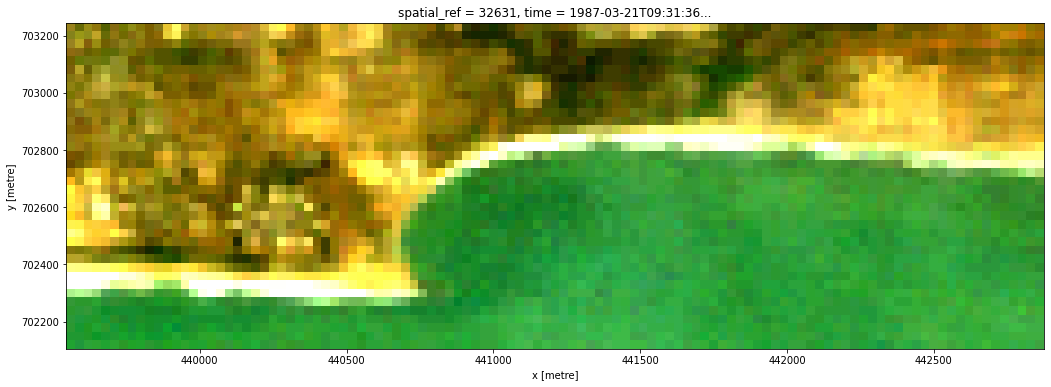

In [7]:
# Set the timesteps to visualise
timestep = 9

# Generate RGB plots at each timestep
rgb(cotonou_ds, 
    index=timestep,
    percentile_stretch=(0.05, 0.95))


## Compute Modified Normalised Difference Water Index
To extract shoreline locations, we need to be able to seperate water from land in our study area. 
To do this, we can use our Landsat data to calculate a water index called the `Modified Normalised Difference Water Index`, or MNDWI. 
This index uses the ratio of green and mid-infrared radiation to identify the presence of water [(Xu 2006)](http://www.aari.ru/docs/pub/060804/xuh06.pdf). 
The formula is:

$$
\begin{aligned}
\text{MNDWI} &= \frac{(\text{Green} - \text{MIR})}{(\text{Green} + \text{MIR})}
\end{aligned}
$$

where `Green` is the green band and `MIR` is the mid-infrared band. 
For Landsat, we can use the Short-wave Infrared (SWIR) 1 band as our measure for `MIR`.

When it comes to interpreting the index, **High values (greater than 0, blue colours) typically represent water pixels**, while **low values (less than 0, red colours) represent land**. 
You can use the cell below to calculate and plot one of the images after calculating the index.

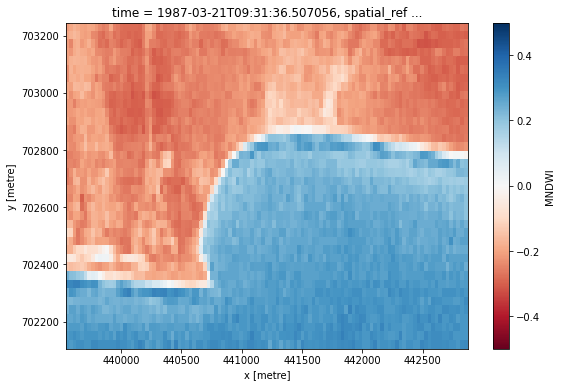

In [8]:
# Calculate the water index
cotonou_ds = calculate_indices(cotonou_ds, index='MNDWI', 
                               collection='c1')

# Plot the resulting image for the same timestep selected above
cotonou_ds.MNDWI.isel(time=timestep).plot(cmap='RdBu',
                                          size=6,
                                          vmin=-0.5,
                                          vmax=0.5)
plt.show()


How does the plot of the index compare to the optical image from earlier? Was there water or land anywhere you weren't expecting?

## Model tide heights
The location of the shoreline can vary greatly from low to high tide. In the code below, we aim to reduce the effect of tides by modelling tide height data, and keeping only the satellite images that were taken at specific tidal conditions. For example, if `tide_range = (0.50, 1.00)`, we are telling the analysis to focus only on satellite images taken when the tide was between median (50th percentile) and maximum conditions (100th percentile).

The `tidal_tag` function below uses the [OTPS TPXO8 tidal model](http://volkov.oce.orst.edu/tides/global.html) to calculate the height of the tide at the exact moment each satellite image in our dataset was taken, and adds this as a new `tide_height` attribute in our dataset. 

**Important note:** this function can only model tides correctly if the centre of your study area is located over water. If this isn't the case, you can specify a custom tide modelling location by passing a coordinate to `tidepost_lat` and `tidepost_lon` (e.g. `tidepost_lat=14.283, tidepost_lon=-16.921`).

In [9]:
# Calculate tides for each timestep in the satellite dataset
cotonou_ds = tidal_tag(ds=cotonou_ds, tidepost_lat=None, tidepost_lon=None)

# Print the output dataset with new `tide_height` variable
print(cotonou_ds)


Setting tide modelling location from dataset centroid: 2.47, 6.36
<xarray.Dataset>
Dimensions:      (time: 330, x: 111, y: 38)
Coordinates:
  * time         (time) datetime64[ns] 1985-04-16T09:39:48.688056 ... 2020-01...
  * y            (y) float64 7.032e+05 7.032e+05 ... 7.022e+05 7.021e+05
  * x            (x) float64 4.396e+05 4.396e+05 ... 4.428e+05 4.429e+05
    spatial_ref  int32 32631
Data variables:
    red          (time, y, x) int16 dask.array<chunksize=(1, 38, 111), meta=np.ndarray>
    green        (time, y, x) int16 dask.array<chunksize=(1, 38, 111), meta=np.ndarray>
    blue         (time, y, x) int16 dask.array<chunksize=(1, 38, 111), meta=np.ndarray>
    swir1        (time, y, x) int16 dask.array<chunksize=(1, 38, 111), meta=np.ndarray>
    MNDWI        (time, y, x) float64 dask.array<chunksize=(1, 38, 111), meta=np.ndarray>
    tide_height  (time) float64 -0.28 -0.426 0.226 ... -0.822 0.175 -0.902
Attributes:
    crs:           epsg:32631
    grid_mapping:  spatial_re

Now that we have modelled tide heights, we can plot them to visualise the range of tide that was captured by Landsat across our time series. In the plot below, red dashed lines also show the subset of the tidal range we selected using the `tide_range` parameter. The plot should make it clear that limiting the range of the tides for the analysis should give you more consistent results. A large variance in the tide height could obscure your results, so consistency is critical as you want to compare the change in the shoreline from year to year.

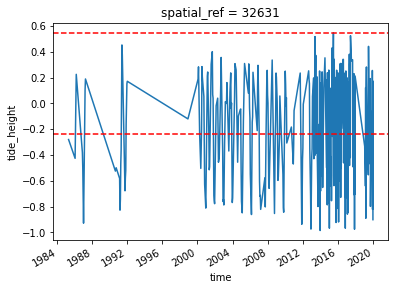

In [10]:
# Calculate the min and max tide heights to include based on the % range
min_tide, max_tide = cotonou_ds.tide_height.quantile(tide_range) 

# Plot the resulting tide heights for each Landsat image:
cotonou_ds.tide_height.plot()
plt.axhline(min_tide, c='red', linestyle='--')
plt.axhline(max_tide, c='red', linestyle='--')
plt.show()


### Filter Landsat images by tide height
Here we take the Landsat dataset and only keep the images with tide heights we want to analyse (i.e. tides within the heights given by `tide_range`). This will result in a smaller number of images (e.g. ~70 images compared to ~140):

In [11]:
# Keep timesteps larger than the min tide, and smaller than the max tide
cotonou_filtered = cotonou_ds.sel(time=(cotonou_ds.tide_height > min_tide) &
                                       (cotonou_ds.tide_height <= max_tide))
print(cotonou_filtered)

<xarray.Dataset>
Dimensions:      (time: 165, x: 111, y: 38)
Coordinates:
  * time         (time) datetime64[ns] 1986-03-02T09:35:26.988050 ... 2020-01...
  * y            (y) float64 7.032e+05 7.032e+05 ... 7.022e+05 7.021e+05
  * x            (x) float64 4.396e+05 4.396e+05 ... 4.428e+05 4.429e+05
    spatial_ref  int32 32631
Data variables:
    red          (time, y, x) int16 dask.array<chunksize=(1, 38, 111), meta=np.ndarray>
    green        (time, y, x) int16 dask.array<chunksize=(1, 38, 111), meta=np.ndarray>
    blue         (time, y, x) int16 dask.array<chunksize=(1, 38, 111), meta=np.ndarray>
    swir1        (time, y, x) int16 dask.array<chunksize=(1, 38, 111), meta=np.ndarray>
    MNDWI        (time, y, x) float64 dask.array<chunksize=(1, 38, 111), meta=np.ndarray>
    tide_height  (time) float64 0.226 0.105 0.19 0.454 ... -0.063 0.256 0.175
Attributes:
    crs:           epsg:32631
    grid_mapping:  spatial_ref


## Combine observations into noise-free summary images
Individual remote sensing images can be affected by noisy data, including clouds, sunglint and poor water quality conditions (e.g. sediment). To produce cleaner images that can be compared more easily across time, we can create 'summary' images or composites that combine multiple images into one image to reveal the median or 'typical' appearance of the landscape for a certain time period. In this case, we use the median as the summary statistic because it prevents strong outliers (like masked cloud values) from skewing the data, which would not be the case if we were to use the mean.

In the code below, we take the time series of images and combine them into single images for each `time_step`. For example, if `time_step = '2Y'`, the code will produce one new image for each two-year period in the dataset. This step can take **several minutes to load** if the study area is large.

>**Note**: We recommend opening the Dask processing window to view the different computations that are being executed; to do this, see the *Dask dashboard in DE Africa* section of the [Dask notebook](../Beginners_guide/06_Parallel_processing_with_dask.ipynb).

In [12]:
# Combine into summary images by `time_step`
cotonou_summaries = (cotonou_filtered.MNDWI
                     .compute()
                     .resample(time=time_step, closed='left')
                     .median('time'))


In [13]:
# Isolating desired timesteps only

cotonou_summaries = cotonou_summaries.isel(time=[1,15,33])

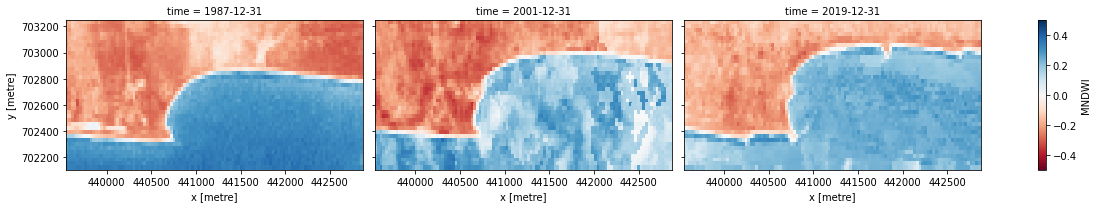

In [14]:
# Plot the output summary images

cotonou_summaries.plot(col='time',
                       cmap='RdBu',
                       col_wrap=3,
                       figsize=(17,3),
                       vmin=-0.5,
                       vmax=0.5)
plt.show()

## Extract shorelines from imagery
We now want to extract an accurate shoreline for each each of the summary images above (e.g. 2014, 2015 etc. summaries). 
The code below identifies the boundary between land and water by tracing a line along pixels with a water index value of `0` (halfway between land and water water index values). 
It returns a shapefile with one line for each time step:


Operating in single z-value, multiple arrays mode
Writing contours to output_waterlines_cotonou.geojson


/env/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


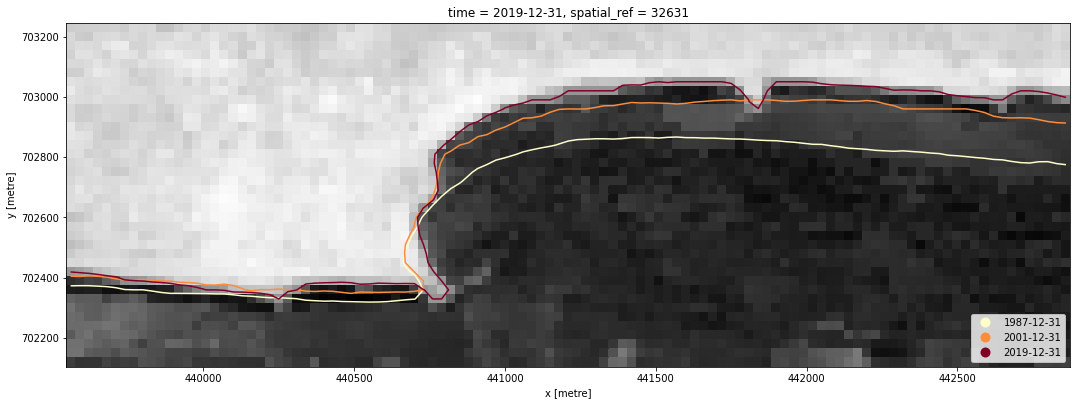

In [15]:
# Set up attributes to assign to each waterline
attribute_data = {'time': [str(i)[0:10] for i in cotonou_summaries.time.values]}
attribute_dtypes = {'time': 'str'}

# Extract waterline contours for the '0' water index threshold:
contour_gdf = subpixel_contours(da=cotonou_summaries,
                                 z_values=0,
                                 crs=cotonou_ds.geobox.crs,
                                 affine=cotonou_ds.geobox.transform,
                                 output_path=f'output_waterlines_cotonou.geojson',
                                 min_vertices=50)

# Plot output shapefile over the first MNDWI layer in the time series
cotonou_summaries.isel(time=-1).plot(size=12, 
                                    cmap='Greys', 
                                    add_colorbar=False)

# add the contours to the plot
contour_gdf.plot(ax=plt.gca(), 
                 column='time', 
                 cmap='YlOrRd', 
                 legend=True, 
                 legend_kwds={'loc': 'lower right'})
plt.show()

The above plot is a basic visualisation of the contours returned by the `contour_extract` function. 
Given we now have the shapefile, we can use a more complex function to make an interactive plot for viewing the change in shoreline over time below.

### Plot interactive map of output shorelines coloured by time
The next cell provides an interactive map with an overlay of the shorelines identified in the previous cell. Run it to view the map (this step can take **several minutes to load** if the study area is large).

Zoom in to the map below to explore the resulting set of shorelines. 
Older shorelines are coloured in yellow, and more recent shorelines in red.
Hover over the lines to see the time period for each shoreline printed above the map.
Using this data, we can easily identify areas of coastline or rivers that have changed significantly over time, or areas that have remained stable over the entire time period. 


In [16]:
map_shapefile(gdf=contour_gdf, attribute='time', hover_col='time')


Label(value='')

Map(center=[6.356875757997787, 2.468430772673353], controls=(ZoomControl(options=['position', 'zoom_in_text', …

## Area 2: Grand Popo 

Similar steps can be used to inspect an area of the lagoon between Grand Popo and Laguna of Ouidah. Over a four-year period, we see an appreciable change in the sandbars nearest the ocean.

In [17]:
# Define the area of interest

# Grand Popo Lagoon
lat = 6.287323
lon = 1.918

buffer = 0.015

lat_range = (lat-buffer, lat+buffer)
lon_range = (lon-buffer, lon+buffer)

time_range = ('2010', '2017')

# The query must be re-run to absorb the new values
query = {
    'x': lon_range,
    'y': lat_range,
    'time': time_range,
    'measurements': ['red', 'green', 'blue', 'swir1'],
    'resolution': (-30, 30),
}

# Load data from Landsat 8
lagoon_ds = load_ard(dc=dc, 
                      products=['ls8_usgs_sr_scene'], 
                      output_crs=output_crs,
                      align=(15, 15),
                      dask_chunks={'time': 1},
                      group_by='solar_day',
                      **query)

Using pixel quality parameters for USGS Collection 1
Finding datasets
    ls8_usgs_sr_scene
Applying pixel quality/cloud mask
Returning 83 time steps as a dask array


In [18]:
display_map(x=lon_range, y=lat_range)

In [19]:
# Calculate the water index
lagoon_ds = calculate_indices(lagoon_ds, index='MNDWI', 
                               collection='c1')

# Calculate tides
lagoon_ds = tidal_tag(ds=lagoon_ds, tidepost_lat=None, tidepost_lon=None)
min_tide, max_tide = lagoon_ds.tide_height.quantile(tide_range) 

lagoon_filtered = lagoon_ds.sel(time=(lagoon_ds.tide_height > min_tide) &
                                       (lagoon_ds.tide_height <= max_tide))

# Combine into summary images by `time_step`
lagoon_summaries = (lagoon_filtered.MNDWI
                     .compute()
                     .resample(time=time_step, closed='left')
                     .median('time'))

# Isolating desired timesteps
lagoon_summaries = lagoon_summaries.isel(time=[1,3,-1])

Setting tide modelling location from dataset centroid: 1.92, 6.29


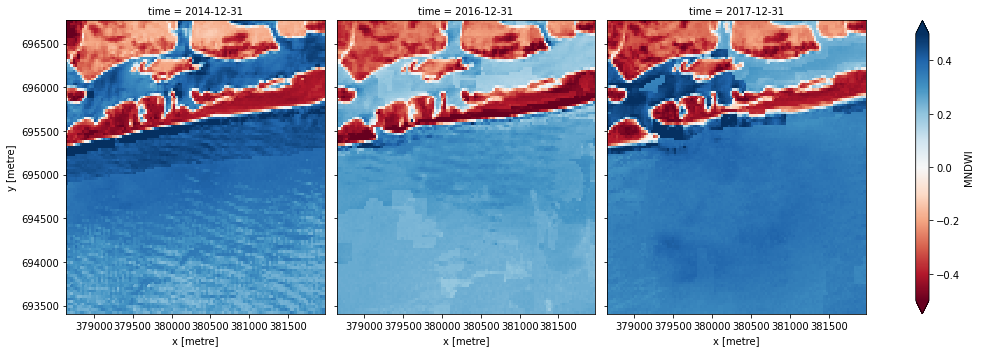

In [20]:
# Plot the output summary images
lagoon_summaries.plot(col='time',
                       figsize=(15,5),
                       cmap='RdBu',
                       col_wrap=3,
                       vmin=-0.5,
                       vmax=0.5)
plt.show()

Operating in single z-value, multiple arrays mode
Writing contours to output_waterlines_lagoon.geojson


/env/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


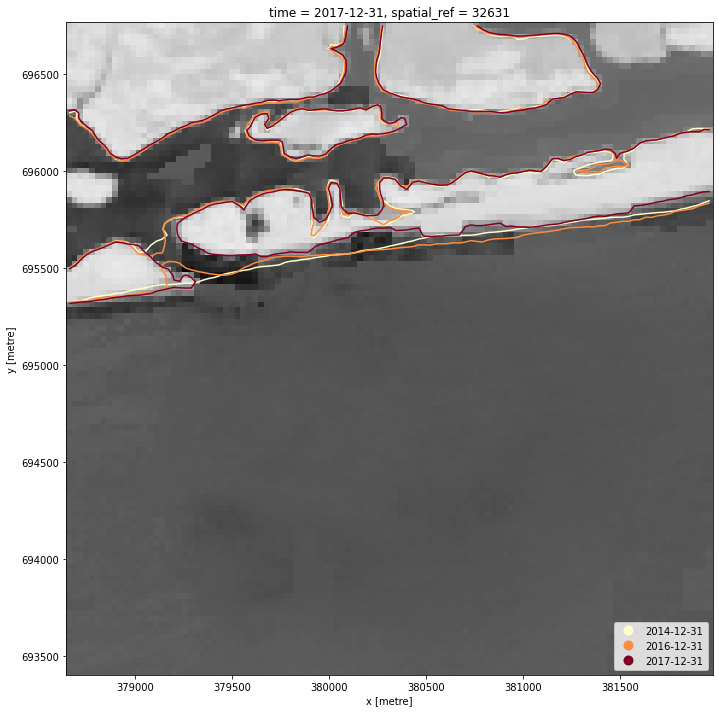

In [21]:
# Set up attributes to assign to each waterline
attribute_data = {'time': [str(i)[0:10] for i in lagoon_summaries.time.values]}
attribute_dtypes = {'time': 'str'}

# Extract waterline contours for the '0' water index threshold:
contour_gdf = subpixel_contours(da=lagoon_summaries,
                                 z_values=0,
                                 crs=lagoon_ds.geobox.crs,
                                 affine=lagoon_ds.geobox.transform,
                                 output_path=f'output_waterlines_lagoon.geojson',
                                 min_vertices=50)

# Plot output shapefile over the first MNDWI layer in the time series
lagoon_summaries.isel(time=-1).plot(size=12, 
                                    cmap='Greys', 
                                    add_colorbar=False)

# add the contours to the plot
contour_gdf.plot(ax=plt.gca(), 
                 column='time', 
                 cmap='YlOrRd', 
                 legend=True, 
                 legend_kwds={'loc': 'lower right'})
plt.show()

## Conclusions

Records of erosion at both the urban area in Cotonou and the lagoon at Grand Popo are verified using Landsat data to identify coastline recession over a period of years.

In the case of Cotonou, the erosion has been mapped over several decades and shows the beach experiencing severe and even erosion towards built-up areas. This has been previously attributed to infrastructure works at the harbour, although artificial headlands have since been constructed to mitigate erosion. The effects of the headlands have not been conclusive, and ongoing monitoring is vital to track the 

For the lagoon at Grand Popo, over a shorter span of time it is clear the sandbar has changed shape and the shoreline has receded inland. This is consistent with literature measuring an annual erosion trend of 1.6 m/year ([Abessolo et al, 2017](https://www.mdpi.com/2073-4441/9/6/447)). It is unclear whether this erosion is caused by urbanisation activity along the coast, or a natural occurrence. Erosion in this area is also impacted by the frequency and severity of tropical storms, which can be related to global climate oscillations and climate change.

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** March 2019

**Compatible `datacube` version:** 

In [22]:
print(datacube.__version__)

1.8.3


## Tags
Browse all available tags on the DE Africa User Guide's [Tags Index]()